## Use NN to create a classifier

Moment tensor based multinomial classifier for Earthquake, Explosion, and Mine/Cavity Collapse targets.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.math import confusion_matrix
from tensorflow.keras.metrics import Recall, CategoricalAccuracy, Precision

from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow_addons.metrics import F1Score

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

import pickle

import warnings
from sklearn import set_config
set_config(display="diagram")
warnings.filterwarnings('ignore')

2023-03-12 18:39:59.383863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


run this only once in the beginning so that the classifier does not change and the results are reproducible

In [2]:
import random as python_random
import numpy as np
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   python_random.seed(1)

In [3]:
print(hash("keras"))

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(123)

import random as python_random
python_random.seed(123)
print(hash("keras"))

tf.random.set_seed(1234)

print(hash("keras"))

8412025554498373698
8412025554498373698
8412025554498373698


read in the data

In [4]:
df = pd.read_csv( "data/ML_mt_geysers.csv")

map the numerical label column to string label based on event dictionary

In [5]:
event_dict = { 0:'eq', 1:'ex', 2:'co' }
df['etype'] = df['label'].map(event_dict)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lune_lon     1440 non-null   float64
 1   lune_lat     1440 non-null   float64
 2   pvr          1440 non-null   float64
 3   pdc          1440 non-null   int64  
 4   pclvd        1440 non-null   int64  
 5   piso         1440 non-null   int64  
 6   Mo           1440 non-null   float64
 7   mxx          1440 non-null   float64
 8   myy          1440 non-null   float64
 9   mzz          1440 non-null   float64
 10  mxy          1440 non-null   float64
 11  mxz          1440 non-null   float64
 12  myz          1440 non-null   float64
 13  eig1         1440 non-null   float64
 14  eig2         1440 non-null   float64
 15  eig3         1440 non-null   float64
 16  origin_time  1440 non-null   object 
 17  lat          1440 non-null   float64
 18  lon          1440 non-null   float64
 19  momag 

The selected features are the lune parameters lune_lat, lune_lon a spherical projection of the eigenvalues of the moment tensor

In [7]:
features_lune = ['lune_lat', 'lune_lon']
# features_mt = ['mxx', 'myy', 'mzz', 'mxy', 'mxz', 'myz']
# X = df[features_mt]
X = df[features_lune]
y =  df[['label']]
print(X.shape, y.shape)

(1440, 2) (1440, 1)


For tensorflow keras use label binarizer to one-hot encode the target 

In [8]:
lb = LabelBinarizer()
y_ohe = lb.fit_transform(y)

In [9]:
# y_ohe[1400:1420,:]
# y[1400:1420]
# lb.inverse_transform(y_ohe[1400:1420,:])
# y_ohe.shape

Since the dataset is small (1400 values), then we made a larger 40% test set. 
This is the same split used by other notebook ichinose-capstone-version4.ipynb

In [10]:
X_train, X_test, y_train, y_test = train_test_split( X, y_ohe, test_size=0.4, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(864, 2)
(576, 2)
(864, 3)
(576, 3)


### We created a simple 2 neuron input layer,  1 layer - 2 neuron hidden layer with sigmoid activation function, and softmax output layer (3 classes). 

Recall is the metric which we wanted to use based on bussiness choice but this lead to a lot of false alarms.  We decided to use f1-score as a balance between precision and recall.  We used batch normalization for faster convergence.  

In [11]:
### do this so results are repeatable.
### remove if doing CV testing 
###
reset_random_seeds()

# Dense(  2, input_dim=2, use_bias = False, activation='sigmoid'),
#   Activation("sigmoid"),
# Dropout( rate = 0.25 ),

model1 = Sequential([
    Dense(  2, input_dim=2, use_bias = False, activation="sigmoid" ),
    BatchNormalization(),
    Dense(  3, use_bias = False, activation="softmax"),
])

callback = EarlyStopping(monitor='loss', patience = 20, min_delta = 0.00001, verbose = 1)

# "SGD"
# optim = SGD(learning_rate=0.001)
# "adam"
optim = Adam(learning_rate=0.005)
# "RMSprop"
# optim = RMSprop( learning_rate=0.001 )

# metrics = CategoricalAccuracy( name="categorical_accuracy")
# metrics = Precision( thresholds=0.5, name="precision" )
# metrics = Recall( thresholds = 0.5, class_id=1, top_k=3, name="recall" )
# metrics = Recall( thresholds = 0.5, name="recall" )
metrics = F1Score( num_classes=3, threshold=0.5, name="f1-score", average="weighted" )

2023-03-12 18:40:04.548609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We use early stopping to avoid over fitting

In [12]:
# model1.compile(loss="categorical_crossentropy", metrics=[Recall(thresholds=0.5)], optimizer='sgd')
# loss="categorical_crossentropy", 
#  loss="categorical_hinge",
# model1.compile( loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optim )

model1.compile( loss="categorical_crossentropy", metrics=metrics, optimizer=optim )
             
# model1.compile( loss="categorical_crossentropy", metrics=['accuracy'], optimizer='adam')

history1 = model1.fit(  X_train, y_train, 
                        validation_data = (X_test, y_test), 
                      shuffle=False,
                        epochs=500, 
                      verbose=1)

# callbacks=[callback], 

# print(history1.history)

Epoch 1/500
27/27 [==============================] - 1s 8ms/step - loss: 1.1036 - f1-score: 0.0030 - val_loss: 1.0636 - val_f1-score: 0.0000e+00
Epoch 2/500
27/27 [==============================] - 0s 2ms/step - loss: 1.0778 - f1-score: 0.0047 - val_loss: 1.0359 - val_f1-score: 0.0000e+00
Epoch 3/500
27/27 [==============================] - 0s 2ms/step - loss: 1.0423 - f1-score: 0.0000e+00 - val_loss: 0.9442 - val_f1-score: 0.0000e+00
Epoch 4/500
27/27 [==============================] - 0s 2ms/step - loss: 0.9258 - f1-score: 0.0535 - val_loss: 0.7694 - val_f1-score: 0.7188
Epoch 5/500
27/27 [==============================] - 0s 2ms/step - loss: 0.7239 - f1-score: 0.6192 - val_loss: 0.6239 - val_f1-score: 0.7188
Epoch 6/500
27/27 [==============================] - 0s 2ms/step - loss: 0.5668 - f1-score: 0.7608 - val_loss: 0.5818 - val_f1-score: 0.7188
Epoch 7/500
27/27 [==============================] - 0s 2ms/step - loss: 0.5009 - f1-score: 0.7608 - val_loss: 0.5685 - val_f1-score: 0.71

27/27 [==============================] - 0s 2ms/step - loss: 0.1198 - f1-score: 0.9506 - val_loss: 0.1500 - val_f1-score: 0.9386
Epoch 59/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1178 - f1-score: 0.9522 - val_loss: 0.1540 - val_f1-score: 0.9343
Epoch 60/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1160 - f1-score: 0.9555 - val_loss: 0.1586 - val_f1-score: 0.9231
Epoch 61/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1148 - f1-score: 0.9597 - val_loss: 0.1640 - val_f1-score: 0.9158
Epoch 62/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1150 - f1-score: 0.9608 - val_loss: 0.1574 - val_f1-score: 0.9358
Epoch 63/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1150 - f1-score: 0.9597 - val_loss: 0.1527 - val_f1-score: 0.9291
Epoch 64/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1143 - f1-score: 0.9608 - val_loss: 0.1519 - val_f1-score: 0.9368
Epoch 65/500
27/27 

Epoch 116/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1111 - f1-score: 0.9652 - val_loss: 0.1366 - val_f1-score: 0.9441
Epoch 117/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1123 - f1-score: 0.9583 - val_loss: 0.1403 - val_f1-score: 0.9398
Epoch 118/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1110 - f1-score: 0.9663 - val_loss: 0.1361 - val_f1-score: 0.9441
Epoch 119/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1123 - f1-score: 0.9583 - val_loss: 0.1402 - val_f1-score: 0.9361
Epoch 120/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1110 - f1-score: 0.9652 - val_loss: 0.1368 - val_f1-score: 0.9441
Epoch 121/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1122 - f1-score: 0.9583 - val_loss: 0.1400 - val_f1-score: 0.9377
Epoch 122/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1110 - f1-score: 0.9652 - val_loss: 0.1365 - val_f1-score: 0.9441

27/27 [==============================] - 0s 2ms/step - loss: 0.1119 - f1-score: 0.9596 - val_loss: 0.1399 - val_f1-score: 0.9369
Epoch 174/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1109 - f1-score: 0.9666 - val_loss: 0.1353 - val_f1-score: 0.9425
Epoch 175/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1119 - f1-score: 0.9596 - val_loss: 0.1399 - val_f1-score: 0.9386
Epoch 176/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1109 - f1-score: 0.9666 - val_loss: 0.1353 - val_f1-score: 0.9425
Epoch 177/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1119 - f1-score: 0.9596 - val_loss: 0.1398 - val_f1-score: 0.9386
Epoch 178/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1109 - f1-score: 0.9666 - val_loss: 0.1352 - val_f1-score: 0.9425
Epoch 179/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1119 - f1-score: 0.9596 - val_loss: 0.1398 - val_f1-score: 0.9386
Epoch 180/500

27/27 [==============================] - 0s 2ms/step - loss: 0.1110 - f1-score: 0.9666 - val_loss: 0.1348 - val_f1-score: 0.9409
Epoch 231/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1118 - f1-score: 0.9583 - val_loss: 0.1399 - val_f1-score: 0.9388
Epoch 232/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1110 - f1-score: 0.9666 - val_loss: 0.1348 - val_f1-score: 0.9409
Epoch 233/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1118 - f1-score: 0.9583 - val_loss: 0.1399 - val_f1-score: 0.9388
Epoch 234/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1110 - f1-score: 0.9666 - val_loss: 0.1348 - val_f1-score: 0.9409
Epoch 235/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1118 - f1-score: 0.9583 - val_loss: 0.1399 - val_f1-score: 0.9388
Epoch 236/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1110 - f1-score: 0.9666 - val_loss: 0.1348 - val_f1-score: 0.9409
Epoch 237/500

27/27 [==============================] - 0s 2ms/step - loss: 0.1119 - f1-score: 0.9593 - val_loss: 0.1403 - val_f1-score: 0.9423
Epoch 288/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1113 - f1-score: 0.9619 - val_loss: 0.1355 - val_f1-score: 0.9412
Epoch 289/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1119 - f1-score: 0.9593 - val_loss: 0.1403 - val_f1-score: 0.9423
Epoch 290/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1113 - f1-score: 0.9619 - val_loss: 0.1355 - val_f1-score: 0.9412
Epoch 291/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1119 - f1-score: 0.9593 - val_loss: 0.1403 - val_f1-score: 0.9423
Epoch 292/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1113 - f1-score: 0.9619 - val_loss: 0.1355 - val_f1-score: 0.9412
Epoch 293/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1119 - f1-score: 0.9593 - val_loss: 0.1403 - val_f1-score: 0.9423
Epoch 294/500

27/27 [==============================] - 0s 2ms/step - loss: 0.1113 - f1-score: 0.9618 - val_loss: 0.1361 - val_f1-score: 0.9431
Epoch 345/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1118 - f1-score: 0.9583 - val_loss: 0.1406 - val_f1-score: 0.9423
Epoch 346/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1113 - f1-score: 0.9618 - val_loss: 0.1362 - val_f1-score: 0.9431
Epoch 347/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1118 - f1-score: 0.9583 - val_loss: 0.1406 - val_f1-score: 0.9423
Epoch 348/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1113 - f1-score: 0.9618 - val_loss: 0.1362 - val_f1-score: 0.9449
Epoch 349/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1118 - f1-score: 0.9583 - val_loss: 0.1407 - val_f1-score: 0.9423
Epoch 350/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1113 - f1-score: 0.9618 - val_loss: 0.1362 - val_f1-score: 0.9449
Epoch 351/500

27/27 [==============================] - 0s 2ms/step - loss: 0.1118 - f1-score: 0.9583 - val_loss: 0.1412 - val_f1-score: 0.9425
Epoch 402/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1113 - f1-score: 0.9629 - val_loss: 0.1373 - val_f1-score: 0.9467
Epoch 403/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1118 - f1-score: 0.9583 - val_loss: 0.1413 - val_f1-score: 0.9425
Epoch 404/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1113 - f1-score: 0.9629 - val_loss: 0.1374 - val_f1-score: 0.9485
Epoch 405/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1118 - f1-score: 0.9583 - val_loss: 0.1413 - val_f1-score: 0.9425
Epoch 406/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1113 - f1-score: 0.9629 - val_loss: 0.1374 - val_f1-score: 0.9485
Epoch 407/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1118 - f1-score: 0.9583 - val_loss: 0.1413 - val_f1-score: 0.9425
Epoch 408/500

27/27 [==============================] - 0s 2ms/step - loss: 0.1114 - f1-score: 0.9642 - val_loss: 0.1394 - val_f1-score: 0.9440
Epoch 459/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1119 - f1-score: 0.9596 - val_loss: 0.1426 - val_f1-score: 0.9442
Epoch 460/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1114 - f1-score: 0.9642 - val_loss: 0.1396 - val_f1-score: 0.9424
Epoch 461/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1119 - f1-score: 0.9596 - val_loss: 0.1428 - val_f1-score: 0.9442
Epoch 462/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1114 - f1-score: 0.9642 - val_loss: 0.1399 - val_f1-score: 0.9424
Epoch 463/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1119 - f1-score: 0.9596 - val_loss: 0.1430 - val_f1-score: 0.9442
Epoch 464/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1114 - f1-score: 0.9642 - val_loss: 0.1402 - val_f1-score: 0.9424
Epoch 465/500

save the ANN classifier model for use later prediction 

In [13]:
weights_save = model1.get_weights()
print( len(weights_save) )

for i in range(0,len(weights_save)):
    print("weights:", i, weights_save[i].flatten())

6
weights: 0 [-0.02488455  0.025343    0.00699091 -0.00536224]
weights: 1 [2.194057   0.21611728]
weights: 2 [1.134714 2.749655]
weights: 3 [0.44425216 0.556062  ]
weights: 4 [0.02084829 0.02051426]
weights: 5 [ 0.05803718 -2.7916648   1.8292649   1.4554207  -0.06269737 -3.0305874 ]


In [25]:
# weights_save = model1.get_weights()
# print( len(weights_save) )
# 
# for i in range(0,len(weights_save)):
#    print("weights:", i, weights_save[i].flatten())

6

weights: 0 [-0.02488455  0.025343    0.00699091 -0.00536224]

weights: 1 [2.194057   0.21611728]

weights: 2 [1.134714 2.749655]

weights: 3 [0.44425216 0.556062  ]

weights: 4 [0.02084829 0.02051426]

weights: 5 [ 0.05803718 -2.7916648   1.8292649   1.4554207  -0.06269737 -3.0305874 ]

In [15]:
print(model1.summary())
filename = 'output/nn.sav'
pickle.dump(model1, open(filename,'wb'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 4         
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 6         
                                                                 
Total params: 18
Trainable params: 14
Non-trainable params: 4
_________________________________________________________________
None
INFO:tensorflow:Assets written to: ram://ff8f7da1-62c8-4534-a51c-01dc2bdeba93/assets


plot the training and validation test metric as a function of training epoch

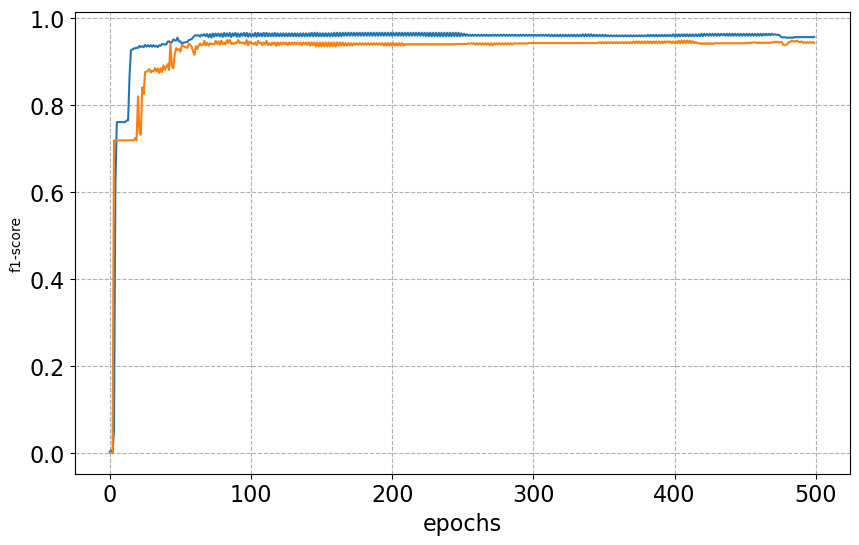

In [16]:
plt.figure(figsize=(10,6))
# plt.plot(history1.history['accuracy'], linewidth=2)
# plt.plot(history1.history['val_accuracy'], linewidth=1)
###
# plt.plot( history1.history["recall"] )
# plt.plot( history1.history['val_recall'] )
###
plt.plot( history1.history["f1-score"])
plt.plot( history1.history['val_f1-score'] )
###
# plt.plot( history1.history["categorical_accuracy"] )
# plt.plot( history1.history['val_categorical_accuracy'] )
###
# plt.plot( history1.history["precision"] )
# plt.plot( history1.history['val_precision'] )
###
plt.grid(linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('epochs',fontsize=16)
# plt.ylabel('accuracy',fontsize=16)
# plt.ylabel('recall')
# plt.ylabel('categorical_accuracy')
# plt.ylabel("precision")
plt.ylabel("f1-score")
plt.show()

plot the training and validation test loss as a function of training epoch

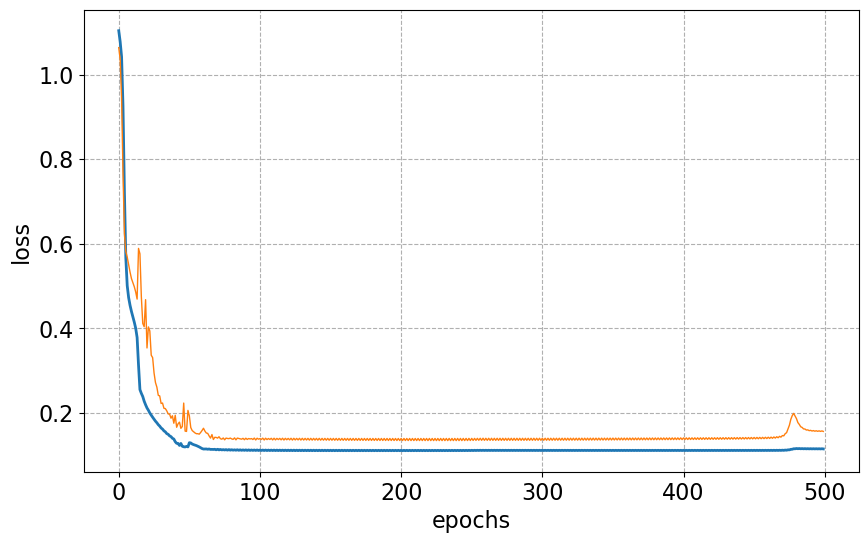

In [17]:
plt.figure(figsize=(10,6))
plt.plot(history1.history['loss'], linewidth=2)
plt.plot(history1.history['val_loss'], linewidth=1 )
plt.grid(linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('epochs',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.show()

compute the confusion matrix from predictions 

In [18]:
labels = lb.inverse_transform(y_test)
# print( type(labels), labels.shape )
y_pred = model1.predict(X_test)
# print( type(y_pred), y_pred.shape )
y_pred_labels = lb.inverse_transform(y_pred)
# print( type(y_pred_labels), y_pred_labels.shape )
#
cm = confusion_matrix( labels, y_pred_labels, num_classes=3 )
print(cm.numpy())

18/18 [==============================] - 0s 769us/step
[[435  25   4]
 [  5  81   0]
 [  0   0  26]]


plot the confusion matrix

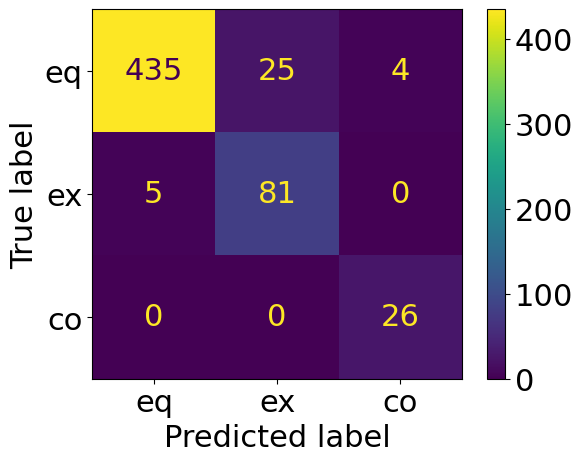

In [19]:
class_labels = ['eq', 'ex', 'co']
# fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams.update({'font.size': 22})
disp = ConfusionMatrixDisplay(confusion_matrix=cm.numpy(), display_labels=class_labels )
disp.plot()
plt.show()

## We are going to append predictions to the original dataframe-X using all the classifiers/estimators and the write them out to be plotted on a sphere to see where the decision lines are placed.

the following function takes the loaded classifier and makes class membership predictions and class probabilities from the input features (in this case the features are synthetic) 

this function is for lune features

In [20]:
#
# load the classifier estimator and do predicts 
# (both class type and individual class probabilities)
# from a list of observed/measured or simulated features
# returns original dataframe with added columns: 
#      columns: class, etype_pred, prob_eq, prob_ex, prob_co 
#
import numpy as np

def physics_test_predict_lune( clf, X, class_labels ):
    # np.set_printoptions(precision=3, suppress=True)
    # np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    #
    nrows = len(X)
    probs = clf.predict(X)
    idx = np.argmax(probs,axis=1)
    
    etype = np.empty(nrows, dtype=object)
    for i in range(nrows):
        etype[i] = class_labels[int(idx[i])]
            
    X['class'] = idx[:]
    X['etype_pred'] = etype[:]
    X['prob_eq'] = probs[:,0]
    X['prob_ex'] = probs[:,1]
    X['prob_co'] = probs[:,2]
    # X['lune_lon'] = lune['lune_lon']
    # X['lune_lat'] = lune['lune_lat']

    return(X)

the function is similar to above but for testing the moment tensor features

In [21]:
#
# load the classifier estimator and do predicts 
# (both class type and individual class probabilities)
# from a list of observed/measured or simulated features
# returns original dataframe with added columns: 
#      columns: class, etype_pred, prob_eq, prob_ex, prob_co 
#
import numpy as np

def physics_test_predict_mt( clf, X, lune, class_labels ):
    # np.set_printoptions(precision=3, suppress=True)
    # np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    #
    nrows = len(X)
    probs = clf.predict(X)
    idx = np.argmax(probs,axis=1)
    
    etype = np.empty(nrows, dtype=object)
    for i in range(nrows):
        etype[i] = class_labels[int(idx[i])]
            
    X['class'] = idx[:]
    X['etype_pred'] = etype[:]
    X['prob_eq'] = probs[:,0]
    X['prob_ex'] = probs[:,1]
    X['prob_co'] = probs[:,2]
    X['lune_lon'] = lune['lune_lon']
    X['lune_lat'] = lune['lune_lat']

    return(X)

### We loaded a sest of 50,005 precomputed lune_lon, and lune_lat features.  These were uniformly distributed on an eigenvalue sphere.  The values were simulate using a C-code.  

In [22]:
df_syn = pd.read_csv( "data/lune2mt.csv")    
df_syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lune_lon  50005 non-null  float64
 1   lune_lat  50005 non-null  float64
 2   pvr       50005 non-null  float64
 3   pdc       50005 non-null  float64
 4   pclvd     50005 non-null  float64
 5   piso      50005 non-null  float64
 6   Mo        50005 non-null  float64
 7   mxx       50005 non-null  float64
 8   myy       50005 non-null  float64
 9   mzz       50005 non-null  float64
 10  mxy       50005 non-null  float64
 11  mxz       50005 non-null  float64
 12  myz       50005 non-null  float64
 13  eig1      50005 non-null  float64
 14  eig2      50005 non-null  float64
 15  eig3      50005 non-null  float64
dtypes: float64(16)
memory usage: 6.1 MB


In [23]:
# features = ['mxx', 'myy', 'mzz', 'mxy', 'mxz', 'myz']
features_lune = ['lune_lat', 'lune_lon']
X_synth = df_syn[features_lune]
#
class_labels = ['eq', 'ex', 'co']
df_lune = df_syn[['lune_lon', 'lune_lat']]
# df_lune.info()

## We are going to append predictions to the original dataframe-X using all the classifiers/estimators and the write them out to be plotted on a sphere to see where the decision lines are placed.

In [24]:
filename = 'output/nn.sav'
load_nn = pickle.load(open(filename, 'rb'))
features_lune = ['lune_lat', 'lune_lon']
features_mt = ['mxx', 'myy', 'mzz', 'mxy', 'mxz', 'myz']
X_synth = df_syn[features_lune]
# X_new = physics_test_predict_mt( load_nn, X_synth, df_lune, class_labels )
X_new = physics_test_predict_lune( load_nn, X_synth, class_labels )
X_new.to_csv('output/nn.lune.csv', index=False)  
# X_new

1563/1563 [==============================] - 1s 610us/step


![Lune plot for ANN](output/nn.lune.lune.jpg)

### go to output directory and use C-sh script to plot the output 